In [22]:
import os
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from datetime import datetime

plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'figure.autolayout': True})

from data.toy_data.hyperbolic import hyperbolic
from data.toy_data.circle import circle
from data.toy_data.spiral import twospirals

from src.diffeomorphisms.iresnet_euclidean_product import i_ResNet_into_Euclidean
from src.manifolds.euclidean import Euclidean
from src.manifolds.pull_back_manifold import PullBackManifold
from src.riemannian_autoencoder import Curvature_Corrected_Riemannian_Autoencoder
from src.riemannian_autoencoder.low_rank_approximation.naive_tsvd import naive_low_rank_approximation
from src.utils.isomap import make_adjacency, get_path, isomap
from src.utils.neural_network.distance_data_set import DistanceData

# set seed
torch.manual_seed(31)

results_path = os.path.join("results")

In [18]:
# data parameters
num_data = 51
noise = 0.1

# iresnet parameters
s_nBlocks = 100 
s_max_iter_inverse = 50
s_int_features = 10 
s_coeff = 0.8 
s_n_power_iter = 10 

# variational problem parameters
alpha_sub = 10.
alpha_iso = 1/100

n_epochs = 20

# plot options
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

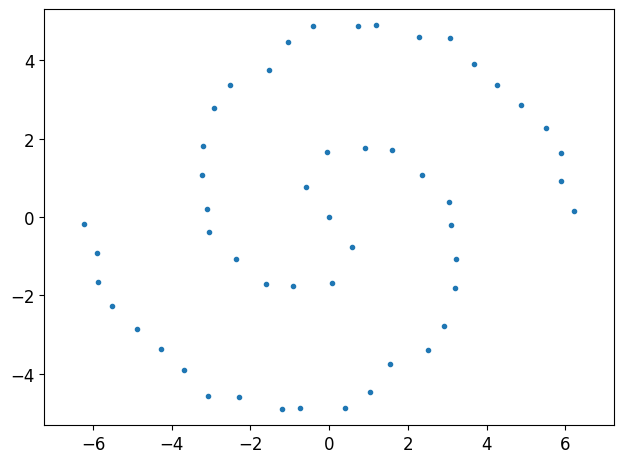

In [3]:
s_data = twospirals(int((num_data-1)/2), noise=noise)
s_data_manifold = twospirals(250, noise=0.)

plt.plot(s_data[:,0], s_data[:,1], '.', color=colors[0])
plt.axis('equal')
plt.savefig(os.path.join(results_path,f"s_data.eps"))
plt.show()

In [4]:
# load parameters
trained_networks_path = os.path.join("models", "spiral")
s_z_path = os.path.join(trained_networks_path, "z.pt")
s_O_path = os.path.join(trained_networks_path, "O.pt")

# load s_offset and s_orthogonal
s_offset = torch.load(s_z_path)
s_orthogonal = torch.load(s_O_path)

# load experiment-dependent pullback manifolds and losses
s_M_dict = {}
s_loss_progession_dict = {}
figure_label_dict = {}
for i in range(2):
    for j in range(2):
        # load differomorphisms
        s_phi_path = os.path.join(trained_networks_path, 
                                  "i_resnet_euclidean_product_{}_blocks_{}_int_features_{}_epochs_{}_subspace_reg_{}_isometry_reg.pt".format(
                                      s_nBlocks, s_int_features, n_epochs, bool(i), bool(j))
                                  )
        s_diffeo = i_ResNet_into_Euclidean([1,1], s_offset, s_orthogonal, 
                          nBlocks=s_nBlocks, max_iter_inverse=s_max_iter_inverse, int_features=s_int_features, coeff=s_coeff, n_power_iter=s_n_power_iter) 
        s_diffeo.phi.load_state_dict(torch.load(s_phi_path))
        s_M_dict[f"{i}{j}"] = PullBackManifold(s_diffeo)

        s_loss_progression_path = os.path.join(trained_networks_path, 
                                  "loss_progression_{}_blocks_{}_int_features_{}_epochs_{}_subspace_reg_{}_isometry_reg.pt".format(
                                      s_nBlocks, s_int_features, n_epochs, bool(i), bool(j))
                                  )
        s_loss_progession_dict[f"{i}{j}"] = torch.load(s_loss_progression_path)
        
        figure_label_dict[f"{i}{j}"] = r'$\alpha_{\mathrm{sub}}=$' +f'{i * alpha_sub}, ' + r'$\alpha_{\mathrm{iso}}=$' +f'{j * alpha_iso}'


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


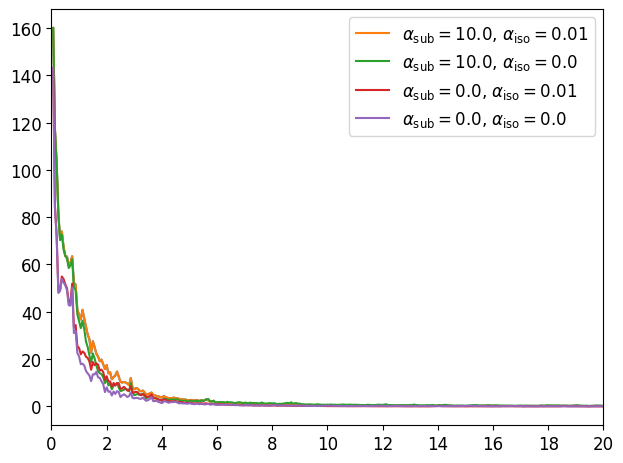

In [43]:
# check that network has actually converged
for i in reversed(range(2)):
    for j in reversed(range(2)):
        s_loss_progression = s_loss_progession_dict[f"{i}{j}"]
        if i == j == 1:
            plt.plot(torch.linspace(n_epochs/len(s_loss_progression), n_epochs, len(s_loss_progression)), s_loss_progression)
        plt.plot(torch.linspace(n_epochs/len(s_loss_progression), n_epochs, len(s_loss_progression)), s_loss_progression, label=figure_label_dict[f"{i}{j}"])

plt.legend()
plt.xlim([0,n_epochs])
plt.xticks([2 * i for i in range(int(n_epochs /2 +1))])
plt.savefig(os.path.join(results_path,f"loss_progressions_on_s_M.eps"))
plt.show()

In [6]:
# check where the diffeomorphisms map into
s_diffeo_data_dict = {}
for i in range(2):
    for j in range(2):
        s_M = s_M_dict[f"{i}{j}"]

        # compute logs to all data
        s_diffeo_data_dict[f"{i}{j}"] = s_M.diffeo.forward(s_data, asproduct=False)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


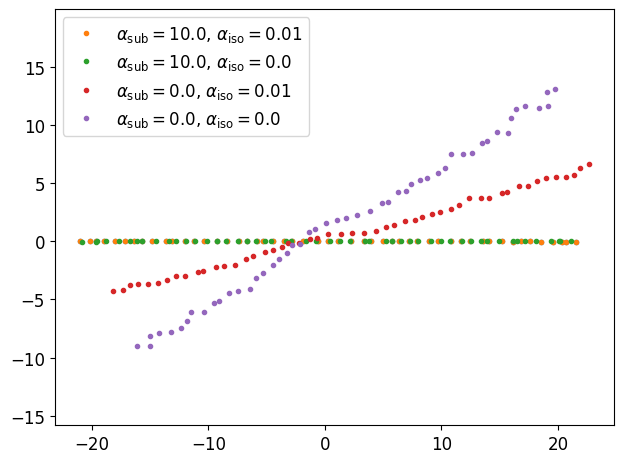

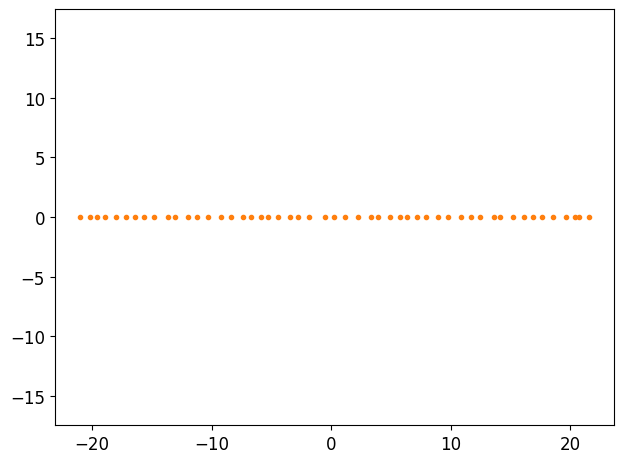

In [55]:
# plot diffeo data set
for i in reversed(range(2)):
    for j in reversed(range(2)):
        if i == j == 1:
            plt.plot(s_diffeo_data_dict[f"{i}{j}"].squeeze().detach().numpy()[:,0], s_diffeo_data_dict[f"{i}{j}"].squeeze().detach().numpy()[:,1], '.')
        plt.plot(s_diffeo_data_dict[f"{i}{j}"].squeeze().detach().numpy()[:,0], s_diffeo_data_dict[f"{i}{j}"].squeeze().detach().numpy()[:,1], '.', 
                 label=figure_label_dict[f"{i}{j}"])

plt.legend()
plt.axis('equal')
plt.savefig(os.path.join(results_path,f"diffeo_data_on_s_M.eps"))
plt.show()

# plot the diffeo data set of the fully diffeomorphisms trained with both subspace regularisation and isometry regularisation once more
plt.plot(s_diffeo_data_dict[f"{1}{1}"].squeeze().detach().numpy()[:,0], s_diffeo_data_dict[f"{1}{1}"].squeeze().detach().numpy()[:,1], '.', color=colors[1])
plt.axis('equal')
plt.savefig(os.path.join(results_path,f"diffeo_on_s_M.eps"))
plt.show()

In [8]:
# choose special points
s_z1 = s_data_manifold[0][None]
s_z2 = s_data_manifold[-1][None]
s_z3 = s_offset[None]

In [9]:
# geodesic interpolation
s_data_gamma_12_t = twospirals(250, noise=0.)
adjacent_distances = torch.norm(s_data_gamma_12_t[1:] - s_data_gamma_12_t[:-1], 2, -1)
cumulative_distances = torch.cat((torch.zeros(1), torch.cumsum(adjacent_distances, 0)),0)
t = cumulative_distances / cumulative_distances[-1]

s_z1_var = s_z1 + 0.5 * torch.tensor([1.,0.])

s_gamma_12_t_dict = {}
error_12_t_dict = {}
s_gamma_12_var_t_dict = {}
error_12_var_t_dict = {}
for i in range(2):
    for j in range(2):
        s_M = s_M_dict[f"{i}{j}"]

        # compute geodesics
        s_gamma_12_t_dict[f"{i}{j}"] =  s_M.geodesic(s_z1, s_z2, t)

        # compute error
        error_12_t_dict[f"{i}{j}"] = torch.norm(s_gamma_12_t_dict[f"{i}{j}"] - s_data_gamma_12_t, 2, -1)

        # compute geodesics variation
        s_gamma_12_var_t_dict[f"{i}{j}"] =  s_M.geodesic(s_z1_var, s_z2, t)

        # compute error wrt original geodesic
        error_12_var_t_dict[f"{i}{j}"] = torch.norm(s_gamma_12_var_t_dict[f"{i}{j}"] - s_gamma_12_t_dict[f"{i}{j}"], 2, -1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


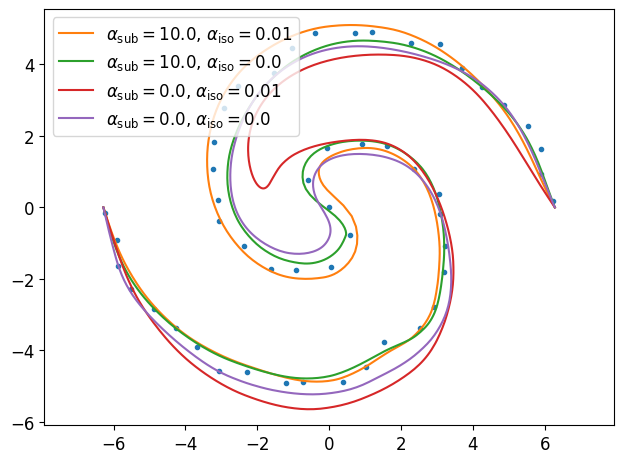

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


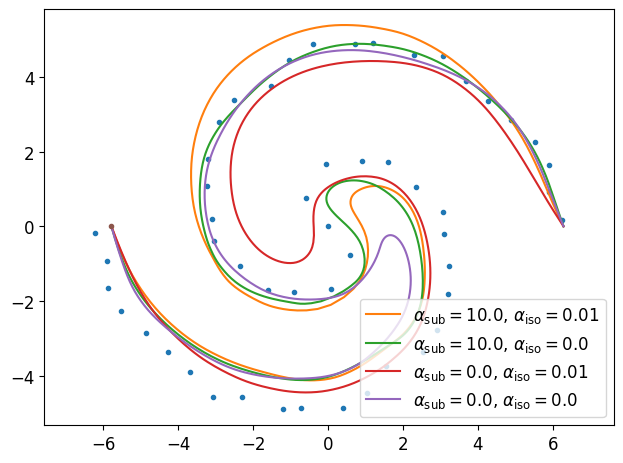

average error = 0.2513752579689026 \pm 0.13864901661872864
average variation error = 0.6235548853874207 \pm 0.44677573442459106
average error = 0.3830943703651428 \pm 0.24089132249355316
average variation error = 1.0320156812667847 \pm 0.8443225622177124
average error = 0.7252686023712158 \pm 0.6765435934066772
average variation error = 0.6786064505577087 \pm 0.48696333169937134
average error = 0.3726065456867218 \pm 0.2029460221529007
average variation error = 0.9096199870109558 \pm 0.6070403456687927


In [54]:
# plot geodesics
plt.plot(s_data[:,0], s_data[:,1], '.')
for i in reversed(range(2)):
    for j in reversed(range(2)):
        plt.plot(s_gamma_12_t_dict[f"{i}{j}"].squeeze().detach().numpy()[:,0], s_gamma_12_t_dict[f"{i}{j}"].squeeze().detach().numpy()[:,1], 
                 label=figure_label_dict[f"{i}{j}"])

plt.legend()
plt.axis('equal')
plt.savefig(os.path.join(results_path,f"geodesics_on_s_M.eps"))
plt.show()

# plot geodesic variations
plt.plot(s_data[:,0], s_data[:,1], '.')
for i in reversed(range(2)):
    for j in reversed(range(2)):
        plt.plot(s_gamma_12_var_t_dict[f"{i}{j}"].squeeze().detach().numpy()[:,0], s_gamma_12_var_t_dict[f"{i}{j}"].squeeze().detach().numpy()[:,1], 
                 label=figure_label_dict[f"{i}{j}"])

plt.plot(s_z1_var[:,0], s_z1_var[:,1], '.', color=colors[5])
plt.legend()
plt.axis('equal')
plt.savefig(os.path.join(results_path,f"geodesic_variations_on_s_M.eps"))
plt.show()

# print errors
for i in reversed(range(2)):
    for j in reversed(range(2)):
        mean_error = torch.mean(error_12_t_dict[f"{i}{j}"])
        std_error = torch.std(error_12_t_dict[f"{i}{j}"])
        print(f"average error = {mean_error.squeeze().detach().numpy()} \pm {std_error.squeeze().detach().numpy()}")

        mean_var_error = torch.mean(error_12_var_t_dict[f"{i}{j}"])
        std_var_error = torch.std(error_12_var_t_dict[f"{i}{j}"])
        print(f"average variation error = {mean_var_error.squeeze().detach().numpy()} \pm {std_var_error.squeeze().detach().numpy()}")

In [11]:
# barycentre
s_data_var = s_data + 0.25 * torch.randn((num_data, 2))
# isometry_error = torch.mean(torch.norm(s_data_var - s_data, 2, -1))

s_barycentre_dict = {}
error_s_barycentre_dict = {}
s_barycentre_var_dict = {}
error_s_barycentre_var_dict = {}
for i in range(2):
    for j in range(2):
        s_M = s_M_dict[f"{i}{j}"]
        
        # compute barycentre
        s_barycentre_dict[f"{i}{j}"] = s_M.barycentre(s_data[None])

        # compute error
        error_s_barycentre_dict[f"{i}{j}"] = torch.norm(s_barycentre_dict[f"{i}{j}"], 2, -1)

        # compute geodesics variation
        s_barycentre_var_dict[f"{i}{j}"] =  s_M.barycentre(s_data_var[None])

        # compute error wrt original geodesic
        error_s_barycentre_var_dict[f"{i}{j}"] = torch.norm(s_barycentre_var_dict[f"{i}{j}"] - s_barycentre_dict[f"{i}{j}"], 2, -1)

/Users/wdiepeveen/Documents/PhD/Projects/10 - Learning Riemannian Geometry/src/article/Pulling-back-symmetric-Riemannian-geometry-for-data-analysis/src/diffeomorphisms/iresnet_euclidean_product.py:34: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3641.)
  return [fwd.T.split([self.d0, self.d1])[0].T, fwd.T.split([self.d0, self.d1])[1].T]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


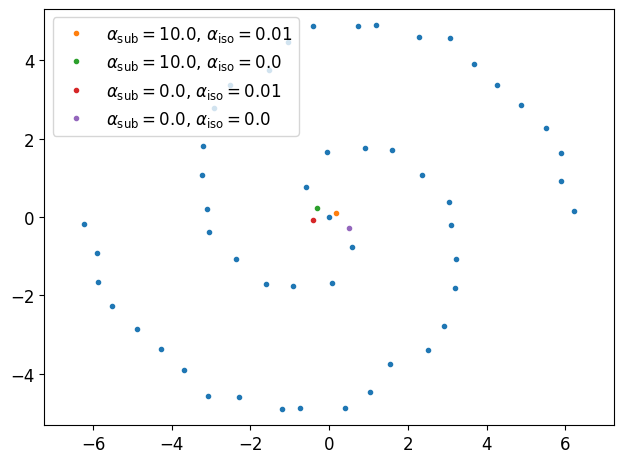

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


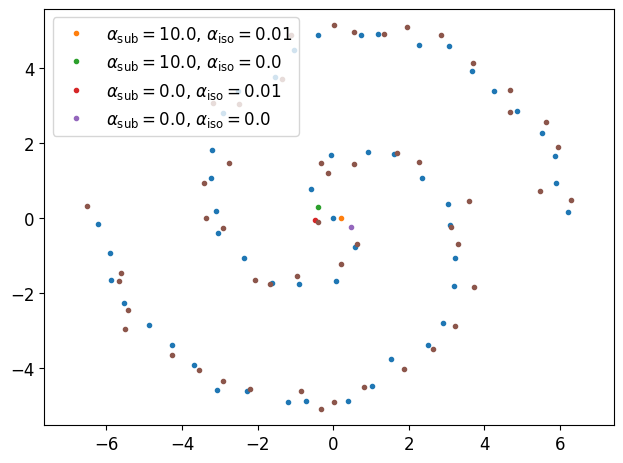

error = 0.21019430458545685
average variation error = 0.11288173496723175
error = 0.3930251896381378
average variation error = 0.11541561037302017
error = 0.4256712794303894
average variation error = 0.058110326528549194
error = 0.5885813236236572
average variation error = 0.06111403927206993


In [53]:
# plot barycentre
plt.plot(s_data[:,0], s_data[:,1], '.')
for i in reversed(range(2)):
    for j in reversed(range(2)):
        plt.plot(s_barycentre_dict[f"{i}{j}"][:,0].detach().numpy(), s_barycentre_dict[f"{i}{j}"][:,1].detach().numpy(), '.', 
                 label=figure_label_dict[f"{i}{j}"])

plt.legend()
plt.axis('equal')
plt.savefig(os.path.join(results_path,f"barycentre_on_s_M.eps"))
plt.show()

plt.plot(s_data[:,0], s_data[:,1], '.')
for i in reversed(range(2)):
    for j in reversed(range(2)):
        plt.plot(s_barycentre_var_dict[f"{i}{j}"][:,0].detach().numpy(), s_barycentre_var_dict[f"{i}{j}"][:,1].detach().numpy(), '.', 
                 label=figure_label_dict[f"{i}{j}"])

plt.plot(s_data_var[:,0], s_data_var[:,1], '.', color=colors[5])

plt.legend()
plt.axis('equal')
plt.savefig(os.path.join(results_path,f"barycentre_variation_on_s_M.eps"))
plt.show()

# print errors
for i in reversed(range(2)):
    for j in reversed(range(2)):
        error = error_s_barycentre_dict[f"{i}{j}"]
        print(f"error = {error.squeeze().detach().numpy()}")

        var_error = error_s_barycentre_var_dict[f"{i}{j}"]
        print(f"average variation error = {var_error.squeeze().detach().numpy()}")

In [13]:
# compute logs
s_logs_dict = {}
for i in range(2):
    for j in range(2):
        s_M = s_M_dict[f"{i}{j}"]

        # compute logs to all data
        s_logs_dict[f"{i}{j}"] = s_M.log(s_z3 * torch.ones((num_data,1)), s_data[:,None])[:,0]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


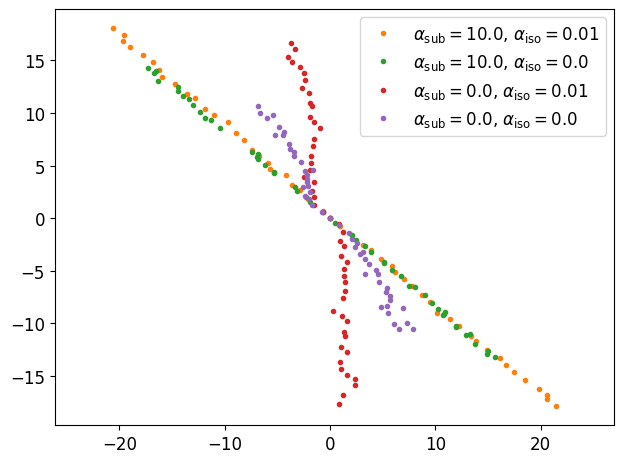

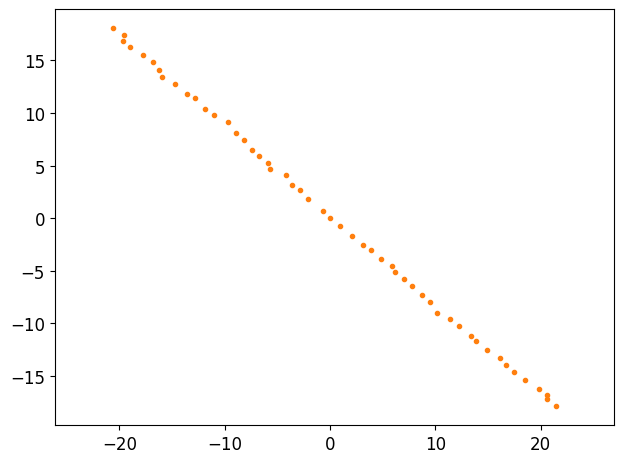

In [57]:
# plot logs
plt.plot(s_offset[0], s_offset[1], '.')
for i in reversed(range(2)):
    for j in reversed(range(2)):
        plt.plot(s_logs_dict[f"{i}{j}"].squeeze().detach().numpy()[:,0], s_logs_dict[f"{i}{j}"].squeeze().detach().numpy()[:,1], '.', 
                 label=figure_label_dict[f"{i}{j}"])

plt.legend()
plt.axis('equal')
plt.savefig(os.path.join(results_path,f"logs_on_s_M.eps"))
plt.show()

# plot the logs of the fully diffeomorphisms trained with both subspace regularisation and isometry regularisation once more
plt.plot(s_logs_dict[f"{1}{1}"].squeeze().detach().numpy()[:,0], s_logs_dict[f"{1}{1}"].squeeze().detach().numpy()[:,1], '.', color=colors[1])
plt.axis('equal')
plt.savefig(os.path.join(results_path,f"log_on_s_M.eps"))
plt.show()

In [15]:
# low rank approximation
noisy_s_data = twospirals(250, noise=0.25)

projected_s_mesh_dict = {}
error_projected_s_mesh_dict = {}
for i in range(2):
    for j in range(2):
        s_M = s_M_dict[f"{i}{j}"]
        s_z = s_z3

        # i) rank 1 approximation
        s_R_z, s_U = naive_low_rank_approximation(s_M, s_z, s_data, 1)
        s_w_z = s_R_z / s_M.norm(s_z, s_R_z[None])[:,None]

        # ii) construct CC-RAE
        s_rae_w_z = Curvature_Corrected_Riemannian_Autoencoder(s_M, s_z, s_w_z)

        # project noisy validation data onto manifold with RAE
        projected_s_mesh_dict[f"{i}{j}"] = s_rae_w_z.project_on_manifold(noisy_s_data)

        # compute error
        error_projected_s_mesh_dict[f"{i}{j}"] = torch.norm(projected_s_mesh_dict[f"{i}{j}"] - noisy_s_data, 2, -1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


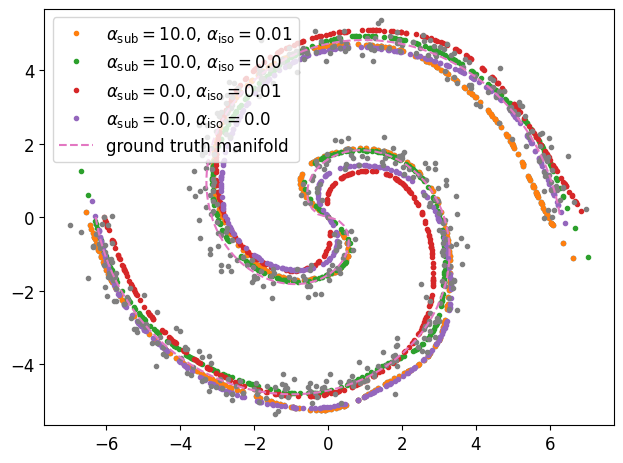

average error = 0.4117802679538727 \pm 0.46597549319267273
average error = 0.5134607553482056 \pm 0.5183206796646118
average error = 0.3581141531467438 \pm 0.2478870451450348
average error = 0.4304153323173523 \pm 0.4064643085002899


In [56]:
# plot rae projections
for i in reversed(range(2)):
    for j in reversed(range(2)):
        if i == j == 1:
            plt.plot(projected_s_mesh_dict[f"{i}{j}"].cpu().detach().numpy()[:,0], projected_s_mesh_dict[f"{i}{j}"].cpu().detach().numpy()[:,1], '.')
        plt.plot(projected_s_mesh_dict[f"{i}{j}"].cpu().detach().numpy()[:,0], projected_s_mesh_dict[f"{i}{j}"].cpu().detach().numpy()[:,1], '.', 
                 label=figure_label_dict[f"{i}{j}"])

plt.plot(noisy_s_data[:,0], noisy_s_data[:,1], '.', color=colors[7])
plt.plot(s_data_manifold[:,0], s_data_manifold[:,1], "--", label="ground truth manifold", color=colors[6])
plt.legend()
plt.axis('equal')
plt.savefig(os.path.join(results_path,f"rae_projections_on_s_M.eps"))
plt.show()

# print errors
for i in reversed(range(2)):
    for j in reversed(range(2)):
        mean_rae_error = torch.mean(error_projected_s_mesh_dict[f"{i}{j}"])
        std_rae_error = torch.std(error_projected_s_mesh_dict[f"{i}{j}"])
        print(f"average error = {mean_rae_error.squeeze().detach().numpy()} \pm {std_rae_error.squeeze().detach().numpy()}")